In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [38]:
def create_bar_graph(df, x_label, y_label, title, legend_labels, legend_loc):
    """
    Create a bar graph from a DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the data to plot. The index should be the x-axis values.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the graph.
    legend_labels (list): List of labels for the legend.
    legend_loc (str): Location of the legend.
    """
    df.plot(kind='line', figsize=(10, 6))  # Changed to 'line' plot
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(legend_labels, loc=legend_loc)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

def create_histogram(df, column, bins, x_label, y_label, title, legend_labels, legend_loc):
    """
    Create a histogram from a DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the data to plot.
    column (str): The column to plot in the histogram.
    bins (int): Number of bins for the histogram.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the graph.
    legend_labels (list): List of labels for the legend.
    legend_loc (str): Location of the legend.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=bins, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(legend_labels, loc=legend_loc)
    plt.tight_layout()
    plt.show()



In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\Kris\AppData\Local\Temp\ipykernel_22560\3564203001.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
# View all of the classes that automap found
table_names = Base.classes.keys()
table_names

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

The date one year ago is: 2016-08-23 00:00:00


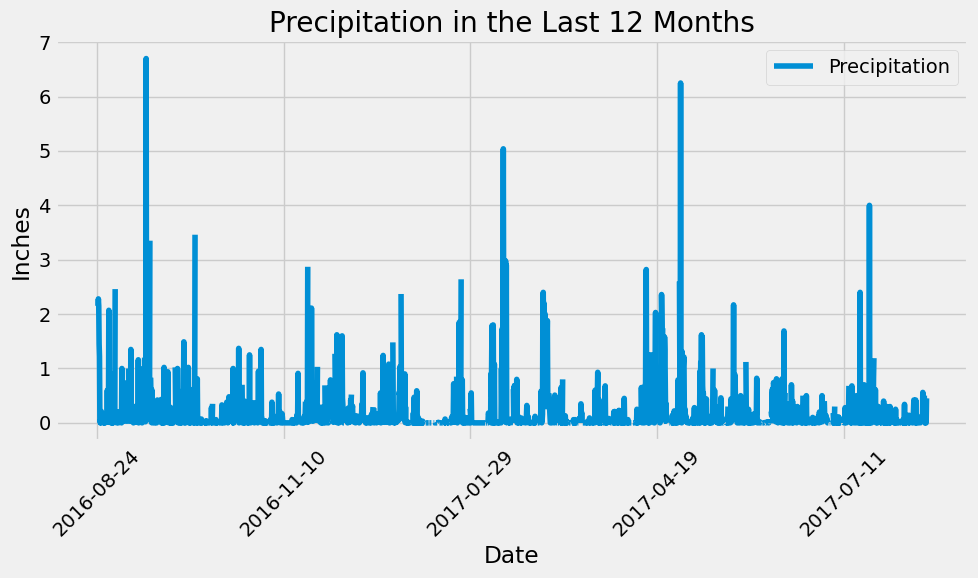

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(f"The date one year ago is: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
create_bar_graph(precipitation_df.set_index('Date'), 'Date', 'Inches', 'Precipitation in the Last 12 Months', ['Precipitation'], 'upper right')

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [32]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())\
                              .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Calculate the lowest, highest, and average temperature for the most active station
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                           .filter(Measurement.station == most_active_station_id)\
                           .all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

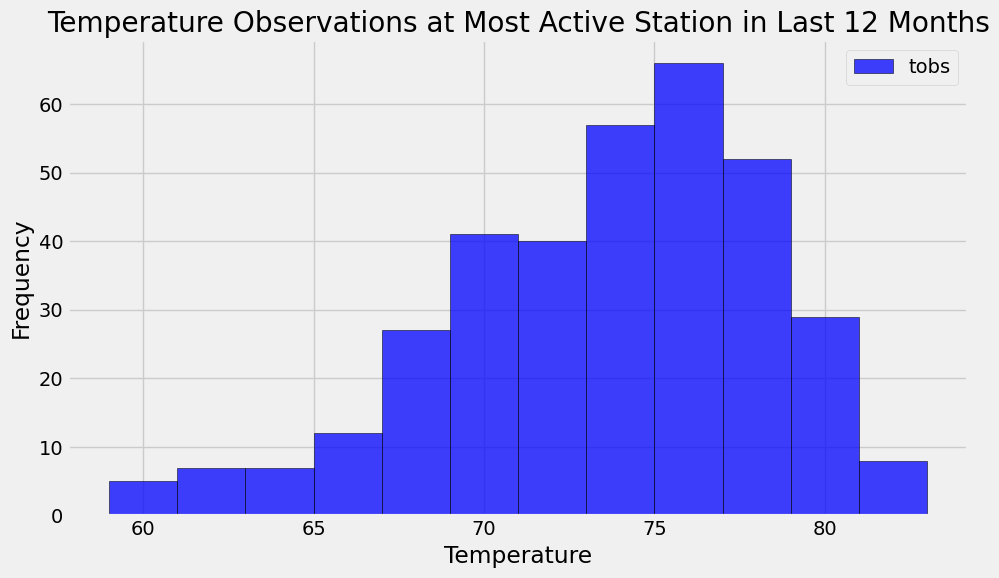

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id).filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Use the function to create the histogram
create_histogram(temperature_df, 'tobs', 12, 'Temperature', 'Frequency', 'Temperature Observations at Most Active Station in Last 12 Months', ['tobs'], 'upper right')


# Close Session

In [16]:
# Close Session
session.close()